Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 07: EEG simulation & filtering in 2-D

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, June 18, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

In this sheet we are going dig deeper into signal processing. Specifically, we will learn how the basic concepts in signal processing expand to 2-D space. You will need to have understandings of what fourier transform and inverse transform do and what kind of effect convolution has.

 Let's say your friend wants to send you a deep picture per messaging app. But he is too afraid that the server might get hacked. Therefore he decides to add some noise in his picture and just sends you the 2d shaped text file of the image. Now you have to denoise the image to see it. Surely you can use a simple filtering function to achieve this, but that sounds too boring for you. Instead, you want to convolve the filter and the image in a spatial domain.

In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import fftpack
from scipy import signal

## Assignment 0: Peer review for sheet 07 [0 pts]

This week there will be no peer-review for obvious reasons.

## Assignment 1: Simulate 4-channel EEG signal [4 pts]

Before starting with the image, we will try to approximate an actual EEG signal as an extension from next week's sheet. Although our later EEG data will be composed of 64 channels, we will stick with 4 for simplicity. 

### a) Generate signal [3 pts]

Write a function that creates the signal for one channel, given a certain frequency-list (4 different frequencies) and the length of the signal. 
Within the function:
- First, define a sampling rate of 1000 Hz and a time-window of 1 second (i.e. 1000 ms)
- Define a list that assigns an amplitude to each element of frequencyList: For this, randomly draw with replacement from a range between 0 and 30 (hint: you need as many amplitude-samples as number of elements in frequencyList, checkout *np.random.choice*)
- Create each signal component with given frequency and amplitude. Add them all up.
- Add a small Gaussian noise to the signal.

In [2]:
def generateSignal(frequencyList,signalLen=1000):
    
    # sampling rate of 1000 Hz
    sampling_rate = 1000
    # time interval of one second in ms
    t = np.linspace(0, 1, sampling_rate, False)

    amplitudes = np.random.choice(30, size=len(frequencyList), replace=True)

    sig = []
    
    #print(frequencyList)
    
    # compute sinusoids according to parameters
    for i, freq in enumerate(frequencyList):
        # append to list of signals
        sig.append(amplitudes[i]*np.sin(2*np.pi*freq[i]*t*(1/sampling_rate)))
    
    signal = sum(sig) + np.random.normal(-1,1,signalLen)
    
    return signal

### b) Plot [1 pt]
Once you wrote the function, use it to create 4 differnet signals (which each represent a channel). To make it more realistic, randomly sample frequencies of each signal from a common EEG frequency-band. These 4 common EEG frequency-bands are already given below.
 
Lastly, plot these 4 different signals.

In [3]:
# define frequency-bands typical for EEG data
delta = list(range(0,4))
theta = list(range(4,8))
alpha = list(range(8,14))
beta = list(range(13,31))
frexlist = [delta, theta, alpha, beta]

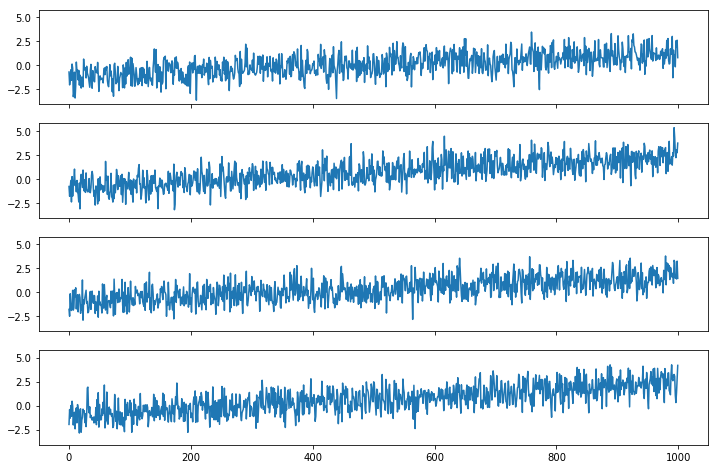

In [4]:
# create 4 signals for each channel, with random frequency combinations
signalList = []
channels = 4
for channel in range(channels):
    signalList.append(generateSignal(frexlist))
   
    
    
#print(np.asarray(signalList).shape())    
    
# plot
# plot all four signals
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(12,8))

axs[0].plot(signalList[0])
axs[1].plot(signalList[1])
axs[2].plot(signalList[2])
axs[3].plot(signalList[3])

plt.show()

### BONUS!
### a) Power-Spectogram
compute and plot the nice and colorful power-spectogram of our signals with *plt.specgram*

C:\Users\kcob4\Anaconda3\envs\acc\lib\site-packages\matplotlib\mlab.py:1246: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=4).
  "(=%d) >= signal length (=%d)." % (NFFT, len(x)))


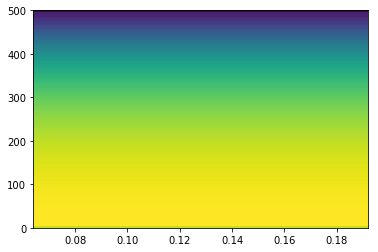

In [5]:
spectrum, freqs, time, im =  plt.specgram(signalList, Fs=1000)

## Assignment 2: Load the data [1 pts]
Now let's start cracking the puzzle. Because your friend just sent you some text file, you need to load them into an image.
- First load the text file into a numpy array.
- Plot this numpy array. Use a gray colormap.

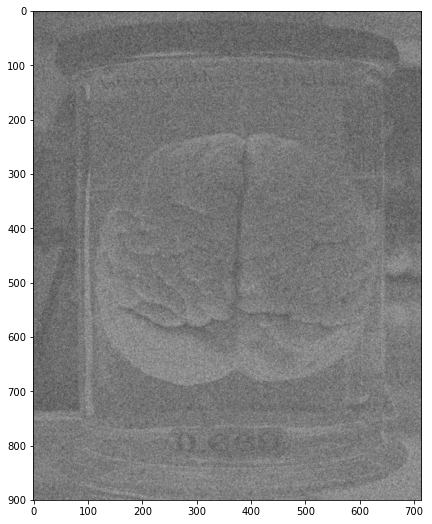

In [6]:
important = np.loadtxt('important.txt')

fig, axs = plt.subplots(1, 1, figsize=(12, 9))

#axs[0].pcolor(important, cmap='gray')
axs.imshow(important, interpolation='gaussian', cmap='gray')

plt.show()

## Asignment 3: Fourier transform [2 pts]
Do a fourier transform on the image.
- Don't panic. It's just the same concept, only in a 2-D space rather than in a 1-D space. 
- If you use ***numpy.fftpack.fft2***, you should shift the zero-frequency component to be at the center by ***numpy.fftpack.fftshift***.
- You should plot the power spectrum of the fourier transformed image at the end. 
- See https://www.gaussianwaves.com/2015/11/interpreting-fft-results-obtaining-magnitude-and-phase-information/ for differences between magnitiude, phase and power (amplitude).
- Use log scale in the plot. Check the parameter @norm of ***matplotlib.pyplot.imshow***.

C:\Users\kcob4\Anaconda3\envs\acc\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


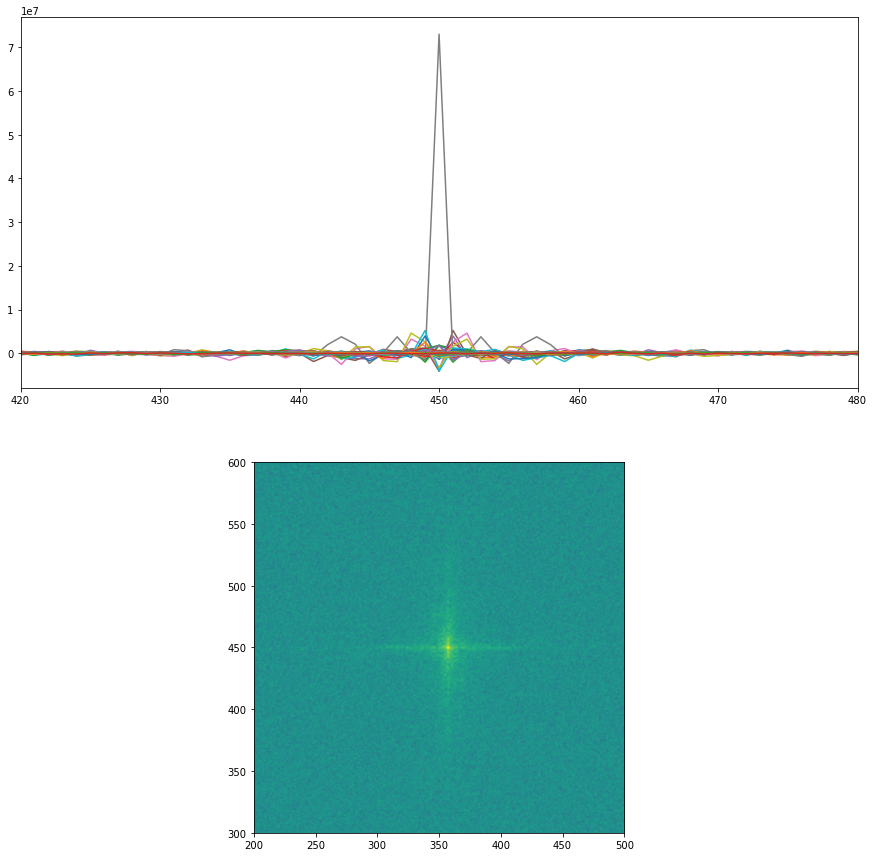

In [7]:
import matplotlib.colors as colors

fourie_im = fftpack.fft2(important)
fourie_im_shift = fftpack.fftshift(fourie_im)

fig, axs = plt.subplots(2,1, figsize=(15,15))

axs[0].plot(fourie_im_shift)
axs[0].set_xlim(420,480)
# Calculate a 2D power spectrum
psd2D = np.abs(fourie_im_shift)**2

axs[1].imshow(psd2D,interpolation='gaussian', norm=colors.LogNorm(vmin=psd2D.min(), vmax=psd2D.max()))#, cmap='gray')
axs[1].set(xlim=(200,500), ylim=(300,600))

plt.show()

## Assignment 4: Create low pass filter [2 pts]
To filter the image, you need a filter. We are going to use a low pass filter (2-D Gaussian). 
- Your distribution should be rotationally symmetric for every angle.
- The filter should have 120 x 120 size, and the standard deviation should be 3.
- In our case it's easy to go from 1-D Gaussian distribution to 2-D Gaussian distribution, because there are no interaction between two dimensions (covariance matrix would be diagonal).
- Plot your filter.

(120, 120)


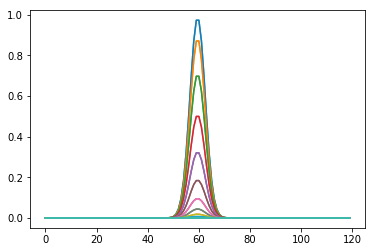

In [12]:
#filter2d = np.random.normal(scale=3, size=(120,120))
#filter2d = np.outer(gaussian, gaussian)
filter1d = signal.gaussian(M=120, std=3, sym=True)
filter2d = np.outer(filter1d, filter1d)

print(filter2d.shape)
plt.plot(filter2d)
plt.show()

## Assignment 5: Back to space [2 pts]
Right now the picture and the filters are both in frequency domain. Let's bring them back to the spatial domain. For this, you can use an inverse fourier transform function (I know, we computed fourier transform of the picture for nothing). 
- Compute the inverse fourier transform for both the image and the kernel.
- Compute power spectrum of these.

In [18]:
im_orig = fftpack.ifft2(fourie_im_shift)
filter2d_orig = fftpack.ifft2(filter2d)

im_orig_ps = np.abs(im_orig)**2
filter2d_orig_ps = np.abs(filter2d)**2

## Assignment 6: Convolution [2 pts]

To boost your intuition of convoultion in 2-d space, I recommend the following blog article.
http://www.songho.ca/dsp/convolution/convolution2d_example.html


We are almost there. Now we just have to convolve the image and the filter in spatial domain (use the computed power spectra of assignment 5 for this) and plot the picture. Do you recognise the object in the picture?

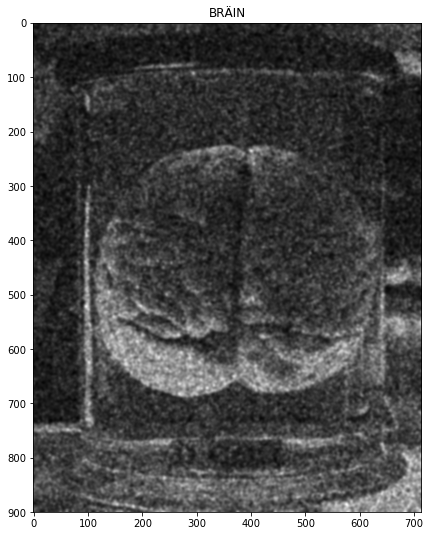

In [20]:
filtered_im = ndimage.convolve(im_orig_ps, filter2d_orig_ps)

fig, axs = plt.subplots(1, 1, figsize=(12, 9))

axs.imshow(filtered_im, interpolation='gaussian', cmap='gray')
axs.set_title('BRÄIN')
plt.show()

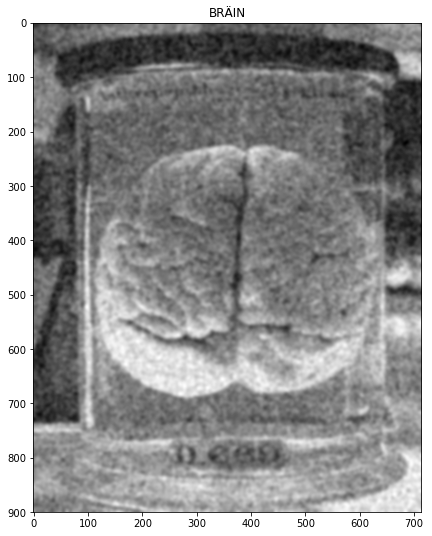

In [15]:
best_filter2d = ndimage.gaussian_filter(important, sigma=3)

fig, axs = plt.subplots(1, 1, figsize=(12, 9))

axs.imshow(best_filter2d, interpolation='gaussian', cmap='gray')
axs.set_title('BRÄIN')
plt.show()

What do you see? 